# Задание 4. SHAP и RDKit. Коррелированные табличные данные и  фингерпринты молекул: AqSolDB

Изучите коррелированность вещественных признаков для датасета [AqSolDB](https://www.nature.com/articles/s41597-019-0151-1), объединяющего информацию о растворимости химических веществ из разных источников. 

Обучите линейную регрессию и оцените важность вещественных признаков, используя веса перед ними. 

Обучите градиентный бустинг из библиотеки XGBoost для вещественных признаков.

Визуализируете важность вещественных признаков в XGBoost используя SHAP.

Ознакомьтесь с векторным представлением молекулы, получаемом RDKit. 

Обучите градиентный бустинг из библиотеки XGBoost для фингерпринтов молекул. 

Визуализируйте 10 самых важных для растворимости частей молекул.

Визуализируйте самые важные признаки молекулы из тестового набора для которой предсказана наименьшая растворимость.





## Формат результата


В результате выполнения задания необходимо получить: 
* таблицу с оценкой важности признаков с помощью весов перед ними для линейной регрессии
* таблицу важности признаков для XGBoost
* SHAP визуализацию важности признаков XGBoost

Примеры визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX10/Ex_10_z4_shap_waterfall.png"  width="500">
<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX10/Ex_10_z4_shap_bar.png"  width="500">

* список 10 самых важных для расстворисоти частей молекул
* RDKit визуализирузация 10 самых важных для растворимости частей молекул

Пример визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX10/Ex_10_z4_fingerprint.png"  width="200">

* RDKit визуализация самых важных признаков молекулы из тестового набора, для которой предсказана наименьшая растворимость.


## Коррелированность вещественных признаков

Импорт библиотек:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

from IPython.display import clear_output

try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    clear_output()
    import shap

try:
    import rdkit
except ModuleNotFoundError:
    !pip install rdkit-pypi
    clear_output()
    import rdkit

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

Загрузка датасета:

In [ ]:
!wget  https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX10/curated-solubility-dataset.csv

data = pd.read_csv("curated-solubility-dataset.csv")
data.head()

--2022-12-08 09:20:20--  https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX10/curated-solubility-dataset.csv
Resolving edunet.kea.su (edunet.kea.su)... 188.44.53.138
Connecting to edunet.kea.su (edunet.kea.su)|188.44.53.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3750208 (3.6M) [application/octet-stream]
Saving to: ‘curated-solubility-dataset.csv’

curated-solubility- 100%[===================>]   3.58M  1.56MB/s    in 2.3s    

2022-12-08 09:20:24 (1.56 MB/s) - ‘curated-solubility-dataset.csv’ saved [3750208/3750208]



,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


Разобиение данных на обучение, валидацию и тест

In [ ]:
all_train_ids, test_ids = train_test_split(np.arange(0, data.shape[0]), test_size=0.25, random_state=777)
train_ids, val_ids = train_test_split(all_train_ids, test_size=0.25, random_state=777)

In [ ]:
X = data.drop("Solubility", axis=1)
X_train, X_val, X_test = X.iloc[train_ids,:], X.iloc[val_ids,:], X.iloc[test_ids,:]

In [ ]:
y = data['Solubility']
y_train, y_val, y_test = y[train_ids], y[val_ids], y[test_ids]

## RDKit. Фингерпринты молекул

Фингерпринты - это векторные описания химических молекул. Их можно получить различными способами. Мы будем использовать один из простейших из библиотеки для работы с химическими веществами `rdkit`

Пример получения [векторного представления молекулы](https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints) 

In [ ]:
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=1, bitInfo=bi, nBits=2 ** 12)
print(fp)

ones_num = []
for i in range(len(fp)):
    if fp[i] != 0:
        ones_num.append(i)
print('Ones: ', ones_num)

bi

Ones:  [29, 458, 1088, 1325, 1380, 2128, 2974, 3067, 3798, 3802, 3921]


{29: ((7, 1),),
 458: ((6, 1),),
 1088: ((1, 1), (2, 1), (3, 1)),
 1325: ((8, 1), (9, 1)),
 1380: ((5, 0),),
 2128: ((6, 0),),
 2974: ((8, 0), (9, 0)),
 3067: ((7, 0),),
 3798: ((4, 1), (0, 1)),
 3802: ((5, 1),),
 3921: ((0, 0), (1, 0), (2, 0), (3, 0), (4, 0))}

Генерация [изображений](https://www.rdkit.org/docs/GettingStartedInPython.html#generating-images-of-fingerprint-bits) 

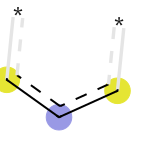

In [ ]:
Draw.DrawMorganBit(mol, 1088, bi, useSVG=True, whichExample=0)

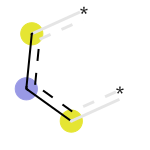

In [ ]:
Draw.DrawMorganBit(mol, 1088, bi, useSVG=True, 
                   whichExample=1)

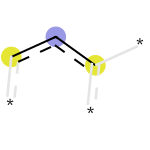

In [ ]:
Draw.DrawMorganBit(mol, 3798, bi, useSVG=True, 
                   whichExample=0)

Функции для подсчета фингерпринтов для всего набора данных

In [ ]:
def compute_fingerpints(smiles, radius=1, size=2 ** 14):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Can't parse {smiles}")
        return np.zeros(size)
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 
                                               radius=radius, 
                                               bitInfo=bi, 
                                               nBits=size)
    return np.array(fp)

def transform_smiles(smi_lst, radius=1, size=2 ** 14):
    X = np.zeros((len(smi_lst), size))
    for ind, smi in enumerate(smi_lst):
        fp = compute_fingerpints(smi, radius, size)
        X[ind] = fp
    return X

 Подготовка данных

In [ ]:
train_features = transform_smiles(X_train['SMILES'])

IndexError: ignored

In [ ]:
val_features = transform_smiles(X_val['SMILES'])

In [ ]:
test_features = transform_smiles(X_test['SMILES'])

##XGBoost для фингерпринтов молекул
Обучите модель

In [ ]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.3)
# Your code here
# model.fit(train_features, y_train, eval_set=...)


Выберите порядка 10 самых важных признаков согласно модели

In [ ]:
print(model.feature_importances_)

In [ ]:
np.sum(model.feature_importances_ > 0)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(model.feature_importances_)
plt.show()

In [ ]:
# Your code here
# imp = ... # numbers of features

In [ ]:
imp.sort(key=lambda x: -model.feature_importances_[x])

In [ ]:
print(imp)

Визуализация изображений частей молекул, отвечающих выбранным самым важным участкам фингерпринта

In [ ]:
examples = defaultdict(list)
for ind, smi in enumerate(X_train['SMILES']):
    positions = list(np.where(train_features[ind] > 0)[0])
    
    for i in imp:
        if i in positions:
            if len(examples[i]) > 10:
                continue
            mol = Chem.MolFromSmiles(smi)
            bi = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 
                                               radius=1, 
                                               bitInfo=bi, 
                                               nBits=2 ** 14)
            mfp2_svg = Draw.DrawMorganBit(mol, i, bi, useSVG=True)
            examples[i].append(mfp2_svg)

In [ ]:
for bit, ex in examples.items():
    print(bit)
    for e in ex:
        display(e)

In [ ]:
print(examples.keys())

Есть ли среди выпавших фрагментов те, которые по идее должны влиять на растворимость молекулы? 

Выберите молекулу из тестового набора, для которой предсказана наименьшая растворимость 

In [ ]:
# Your code here
# pred = model.predict(...)
# min_ind = ...

Визуализация важности признаков

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(test_features)

shap.plots.waterfall(shap_values[min_ind])

Визуализируйте фрагменты молекулы с наибольшей важностью. 

In [ ]:
mol = Chem.MolFromSmiles(X_test.iat[min_ind, 4])
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, 
                                               radius=1, 
                                               bitInfo=bi, 
                                               nBits=2 ** 14)



In [ ]:
# Your code here

In [ ]:
bi